In [1]:
# import sys
# !{sys.executable} -m pip install torch==1.5.1+cpu torchvision==0.6.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import cv2
import os.path
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
%matplotlib inline

In [3]:
class InteriorLandmarksDataset(Dataset):

    def __init__(self, json_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        with open(json_file) as f:
            self.landmarks = json.load(f)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

        img_name = os.path.join(self.img_dir,
                                self.landmarks[idx]["file"])
        image = Image.open(img_name)
        landmarks = self.landmarks[idx]["points"]
        
        segm = np.zeros_like(np.asarray(image))
        segm = cv2.fillPoly(segm, np.array(landmarks, dtype=np.int32), 1)
        segm = Image.fromarray(segm)
        sample = {'image': image, 'segm': segm, 'idx': [idx]}

#         landmarks = np.array([landmarks])
#         landmarks = landmarks.astype('float').reshape(-1, 2)
#         sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = {'image': self.transform(image), 'segm': self.transform(segm), 'idx': [idx]}
            

        return sample

In [4]:
T = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(256),
    transforms.ToTensor(),
])

In [5]:
dataset = InteriorLandmarksDataset('answers.json', 'img', T)

In [6]:
sample = next(iter(dataset))

In [7]:
sample['image'].shape

torch.Size([3, 256, 256])

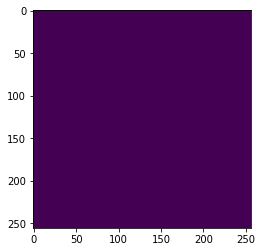

In [8]:
def vis_torch(sample):
    I = sample['image'].numpy().copy()
    
    gt = sample['segm'].numpy().copy()
    I[gt > 0] = 255
    plt.imshow(gt[0])


def vis(sample):
    I = np.asarray(sample['image']).copy()
    
    gt = np.asarray(sample['segm']).copy()
    I[gt > 0] = 255
    
#     for x, y in sample['landmarks']:
#         x, y = int(x), int(y)
#         I[y:y+10, x:x+10] = 0
    plt.imshow(gt)
vis_torch(sample)

In [9]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=4, num_workers=0,
                                          shuffle=True)


Let's play with dataloader and model

In [10]:
minibatch = next(iter(trainloader))

In [11]:
from model import UNet
model = UNet(1)

In [12]:
# %%timeit
pred = model(minibatch['image'])

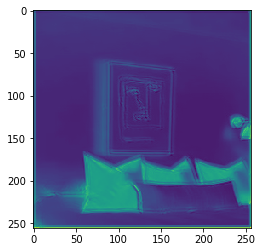

In [13]:
plt.imshow(pred[0, 0].detach().numpy())

In [14]:
from model import UNet
import torch.nn as nn
import torch.optim as optim
model = UNet(3)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=4, num_workers=0,
                                          shuffle=True)

i = 0
for minibatch in trainloader:
    inp = minibatch['image']
    gt = minibatch['segm']
    #ValueError: Target size (torch.Size([4, 3, 256, 256])) must be the same as input size (torch.Size([4, 1, 256, 256]))
    pred = model(inp)
    loss_ = loss(pred, gt)
    print(loss_.item())
    loss_.backward()
    optimizer.step()
    i += 1
    if i > 10:
        break

0.7193081378936768
0.703724205493927


error: OpenCV(4.2.0) C:\projects\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2383: error: (-215:Assertion failed) points.checkVector(2, CV_32S) >= 0 in function 'cv::fillConvexPoly'


In [ ]:
minibatch['idx']

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
model = torch.load('model.pth')

In [ ]:
import cv2
import math
import json
import numpy as np
from os import listdir
from os.path import isfile, join

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)
        

def getTrainingData():
    res = []
    answers = []
    list = [f for f in listdir('img') if isfile(join('img/', f))]
    with open('answers.json') as json_file:
        answers = json.load(json_file)
    for file in list:
        points = []
        for asw in answers:
            if asw['file'] == file:
                points = np.zeros((300,300))
                for x, y in asw['points']:
                    points[x][y] = 1
        res.append({
            'file': file,
            'img': cv2.imread(join('img/', file), 0),
            'points': points
        })
    return res

In [ ]:


data = getTrainingData()
training_inputs = []
training_outputs = []
for i, row in enumerate(data):
    training_inputs.append(row['img'])
    training_outputs.append(row['points'])
    
training_inputs = np.array(training_inputs)
training_outputs = np.array(training_outputs)
np.random.seed(1)

synaptic_weights = 2 * np.random.random((300, 300)) - 1

# print("Random starting synaptic weights:")
# print(synaptic_weights)

for iteration in range(10):
    print('--------------------------------')
    input_layer = training_inputs
    outputs = sigmoid(np.dot(input_layer, synaptic_weights))
    error = training_outputs - outputs
    adjustments = error - sigmoid_derivative(outputs)
    synaptic_weights = np.dot(input_layer.T, adjustments)
    
#     print('training_outputs:')
#     print(len(training_outputs))
    
    print('outputs:')
    print(outputs[1])

    
# print('Synaptic weights after training')
# print(synaptic_weigths)
    
print('Outputs: after training: ')
print(outputs[1])
print('Done')